In [99]:
import numpy as np
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score, 
    average_precision_score
)
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [110]:
class LogRegCCD:
    def __init__(self, lambda_min=1e-3, lambda_max=1.0, num_lambdas=100, alpha=0.2):
        self.lambda_min = lambda_min
        self.lambda_max = lambda_max
        self.num_lambdas = num_lambdas
        self.alpha = alpha
        self.coefficients = None
        self.lambdas = np.logspace(np.log10(lambda_max), np.log10(lambda_min), num_lambdas)
        self.best_lambda = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X_train, y_train, lmbda=None):
        if lmbda is None:
            lmbda = self.lambda_min

        n_samples, n_features = X_train.shape
        self.coefficients = np.zeros(n_features + 1)

        for _ in range(100):
            intercept = self.coefficients[0]
            weights = self.coefficients[1:]
            
            for j in range(n_features):
                partial_residual = y_train - self._sigmoid(np.dot(np.delete(X_train, j, axis=1), np.delete(weights, j)) + intercept)
                gradient = np.dot(X_train[:, j].T, partial_residual.T) / n_samples
                l1_penalty = self.alpha * lmbda
                l2_penalty = (1 - self.alpha) * lmbda
                soft_threshold = np.sign(gradient) * max(0.0, abs(gradient) - l1_penalty)
                weights[j] = soft_threshold.item() / (1 + l2_penalty)
            intercept += np.mean(y_train - self._sigmoid(np.dot(X_train, weights) + intercept))
            self.coefficients[0] = intercept
            self.coefficients[1:] = weights

    def validate(self, X_valid, y_valid, measure="f1"):
        probabilities = self.predict_proba(X_valid)
        predictions = (probabilities >= 0.5).astype(int)
        
        if measure == "precision":
            return precision_score(y_valid, predictions)
        elif measure == "recall":
            return recall_score(y_valid, predictions)
        elif measure == "f1":
            return f1_score(y_valid, predictions)
        elif measure == "balanced_accuracy":
            return balanced_accuracy_score(y_valid, predictions)
        elif measure == "roc_auc":
            return roc_auc_score(y_valid, probabilities)
        elif measure == "pr_auc":
            return average_precision_score(y_valid, probabilities)
        else:
            raise ValueError("Unsupported measure: {}".format(measure))
    def predict_proba(self, X_test):
        return np.asarray(self._sigmoid(np.dot(X_test, self.coefficients[1:]) + self.coefficients[0]).T).reshape(-1)

    def optimize_lambda(self, X_train, y_train, X_valid, y_valid, measure="f1", verbose=0):
        """
        Args:
            verbose (int): log level. 0 for no printing, 1 for progress bar, 2 for detailed info
        """
        best_score = -np.inf
        scores = []
        coeffs_list = []
        
        for lmbda in tqdm(self.lambdas, total=len(self.lambdas), disable=(verbose==0)):
            if verbose == 2:
                print(f'Fitting lmbda: {lmbda}')
            self.fit(X_train, y_train, lmbda)
            score = self.validate(X_valid, y_valid, measure=measure)
            if verbose == 2:
                print(f'{measure.upper()} score: {score}')
            scores.append(score)
            coeffs_list.append(self.coefficients.copy())
            
            if score > best_score:
                best_score = score
                self.best_lambda = lmbda
    
        results = {
            'lambda': self.lambdas,
            'measure': scores,
            'coefficients': coeffs_list
        }
        return results, self.best_lambda

    def plot(self, results, measure="f1"):
        """
        Plot performance measure against lambda values.
        
        Parameters:
        - results: Dictionary returned by optimize_lambda
        - measure: Performance measure to plot
        """
        if not results:
            print("No results to plot. First run optimize_lambda method.")
            return
            
        if measure not in results:
            print(f"Measure '{measure}' not found in results. Available measure: '{list(results.keys())[1]}'")
            print(f"Run optimize_lambda with measure='{measure}' to get these results.")
            return
        
        plt.figure(figsize=(10, 6))
        df = pd.DataFrame(data={'lambda': results['lambda'], measure: results[measure]})
        df.plot(x='lambda', y=measure, logx=True)
        plt.grid(True)
        plt.title(f'{measure.upper()} Score vs Lambda')
        plt.xlabel('Lambda (log scale)')
        plt.ylabel(f'{measure.upper()} Score')
        plt.show()

    def plot_coefficients(self, results):
        """
        Plot coefficient values for different lambda values.
        
        Parameters:
        - results: Dictionary returned by optimize_lambda
        """
        if not results:
            print("No results to plot. First run optimize_lambda method.")
            return
            
        if 'coefficients' not in results:
            print("Coefficient data not found in results.")
            return
        
        plt.figure(figsize=(12, 6))
        lambdas = results['lambda']
        coeffs = results['coefficients']
        
        # Extract each coefficient across all lambda values
        n_features = len(coeffs[0])
        
        for i in range(n_features):
            feature_name = 'Intercept' if i == 0 else f'Feature {i}'
            coef_values = [c[i] for c in coeffs]
            plt.plot(lambdas, coef_values, label=feature_name)
        
        plt.xscale('log')
        plt.grid(True)
        plt.legend()
        plt.title('Coefficient Paths')
        plt.xlabel('Lambda (log scale)')
        plt.ylabel('Coefficient Value')
        plt.show()

In [102]:
from scipy.stats import multivariate_normal, bernoulli


def generate_dataset(p=0.5, n=1000, d=10, g=0.5) -> tuple[np.ndarray, np.ndarray]:
    """
    Generates synthethic dataset

    Args: 
        p: prior probability for y=1
        n: number of instances
        d: number of features
        g: param for cov matrix

    Returns:
        X, y
    """
    y = bernoulli.rvs(p, size=n)
    
    # mean vectors
    m0 = np.zeros(d)
    m1 = np.array([1/(i+1) for i in range(d)])

    # cov matrix
    S = np.array([[g**abs(i - j) for j in range(d)] for i in range(d)])

    X = np.zeros((n, d))
    X[y==0] = multivariate_normal.rvs(mean = m0, cov=S, size=len(X[y==0]))
    X[y==1] = multivariate_normal.rvs(mean = m1, cov=S, size=len(X[y==1]))   

    return X, y

In [104]:
X, y = generate_dataset()

In [105]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

# Save train and validation sets for later use
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_valid.shape, y_valid.shape)

Training set: (700, 10) (700,)
Validation set: (300, 10) (300,)


In [111]:
ccd_model = LogRegCCD(num_lambdas=100, alpha=0.8)
results, bestlambda = ccd_model.optimize_lambda(X_train, y_train, X_valid, y_valid, measure="f1", verbose = 1)
ccd_model.fit(X_train, y_train, ccd_model.best_lambda)

ccd_probs = ccd_model.predict_proba(X_valid)
ccd_preds = (ccd_probs >= 0.5).astype(int)
ccd_f1 = f1_score(y_valid, ccd_preds)
print(f"LogRegCCD F1 Score: {ccd_f1:.4f}")

100%|██████████| 100/100 [00:05<00:00, 17.17it/s]

LogRegCCD F1 Score: 0.7365


In [112]:
logreg = LogisticRegression(penalty=None)
logreg.fit(np.asarray(X_train), y_train)
sklearn_preds = logreg.predict(np.asarray(X_valid))
sklearn_f1 = f1_score(y_valid, sklearn_preds)

In [113]:
sklearn_f1

0.7067137809187279

In [114]:
ccd_model.best_lambda

0.022051307399030443

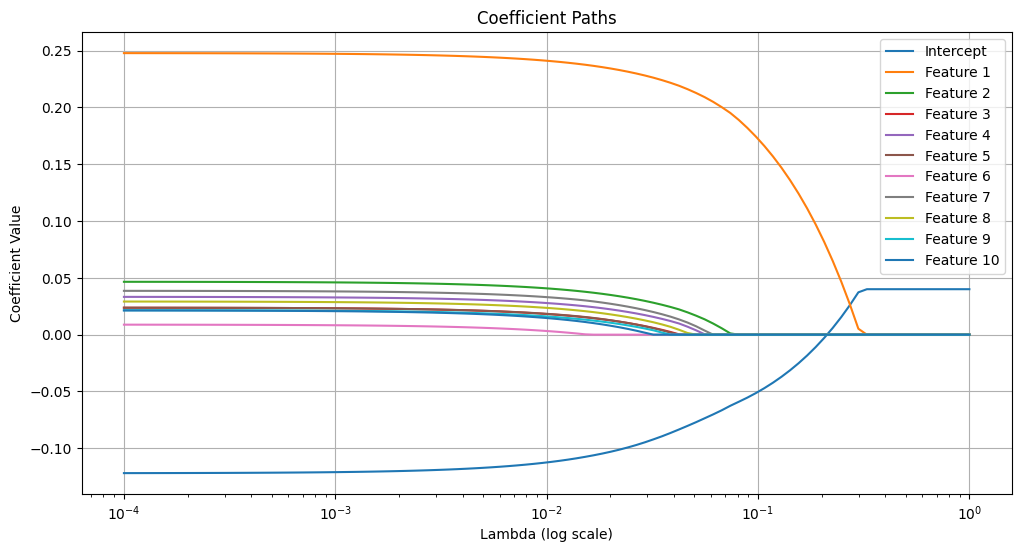

In [115]:
ccd_model.plot_coefficients(results)

In [116]:
ccd_model.plot(results, measure="f1")

Measure 'f1' not found in results. Available measure: 'measure'
Run optimize_lambda with measure='f1' to get these results.
